In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
# import lsqlin
from scipy import stats
import copy 
from sklearn import svm
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn import metrics 
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize
import tensorflow as tf

In [2]:
vix_df = pd.read_excel('VIXfutures_20080414_20201231.xlsx')

vix_df = vix_df.sort_values( by = ['Date'], ascending = True )

x_df = vix_df[ [ 'Date', 'VIX', 'w', \
                       'CMF30', 'CMF60', 'CMF90', 'CMF120', 'CMF150', \
                       'roll30', 'roll60', 'roll90', 'roll120', 'roll150', \
                       'F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9' ] ]

# for eache row, if it contains a non-number element in a column, then drop the entire row
x_df = x_df.dropna()

# for eache row, if it contains a 0 element in a column, then drop the entire row
#x_df = x_df.loc[ ( x_df != 0 ).all( axis = 1 ) ]

# reset the index
x_df= x_df.reset_index( drop = True )

dates = x_df[ 'Date' ]

In [3]:
vix = x_df.VIX 
T = len(vix)

v_1 = x_df.CMF30 
v_2 = x_df.CMF60 
v_3 = x_df.CMF90 
v_4 = x_df.CMF120 
v_5 = x_df.CMF150 

d_theta_log_v_1 = x_df.roll30 
d_theta_log_v_2 = x_df.roll60 
d_theta_log_v_3 = x_df.roll90 
d_theta_log_v_4 = x_df.roll120 
d_theta_log_v_5 = x_df.roll150 

In [4]:
vix_etn_number = 10
x_row = vix_etn_number + 1  #  plus 1 here is for the VIX
x_column = len( v_1 );
X = np.ones( ( x_row, x_column ) )

X[ 0, : ] =  np.log( vix )

X[ 1, : ] =  np.log( v_1 )
X[ 2, : ] =  np.log( v_2 )
X[ 3, : ] =  np.log( v_3 )
X[ 4, : ] =  np.log( v_4 )
X[ 5, : ] =  np.log( v_5 )

X[ 6, : ] = d_theta_log_v_1
X[ 7, : ] = d_theta_log_v_2
X[ 8, : ] = d_theta_log_v_3
X[ 9, : ] = d_theta_log_v_4
X[ 10, : ] = d_theta_log_v_5

In [5]:
#######################################################
####
#### 1-month and 5-month rolling futures portfolios
####
#######################################################

dt = 1/252;
r = .03
vxx = np.zeros(T)
vxz = np.zeros(T)
vxx[0]=100
vxz[0]=100
for t in range(T-1):
    vxx[t+1] = vxx[t]*(1+r*dt + X[ 6, t+1 ]*dt  + (X[ 1, t+1 ]-X[ 1, t ])/X[ 1, t ]  )
    vxz[t+1] = vxz[t]*(1+r*dt + X[ 10, t+1 ]*dt  + (X[ 5, t+1 ]-X[ 5, t ])/X[ 5, t ]  )

r_trade = np.zeros((T-1,5))
r_trade[:,0] = np.ones(T-1)*r*dt
r_trade[:,1] = -np.diff(vxx)/vxx[:-1] + 2*np.diff(vxz)/vxz[:-1]
r_trade[:,2] = -np.diff(vxx)/vxx[:-1] + np.diff(vxz)/vxz[:-1]+r*dt
r_trade[:,3] = np.diff(vxx)/vxx[:-1] - 2*np.diff(vxz)/vxz[:-1]
r_trade[:,4] = np.diff(vxx)/vxx[:-1] - np.diff(vxz)/vxz[:-1]+r*dt

ind_trade = np.zeros((T-1,5)) ### index of max return, to be predicted by classifier
for t in range(T-1):
    ind = np.argmax(r_trade[t,:])
    ind_trade[t,ind] = 1
# y = np.argmax(r_trade,axis=1) # 這樣最快


In [6]:
#######################################################
####
#### divide data into training and testing
####
#######################################################

# 取前半為Train 後半為Test

T_train = int(np.round(T/2))

ind_train = np.arange(0,T_train )
X_train = X[:,ind_train]
y_train = ind_trade[ind_train,:]

ind_test = np.arange(T_train ,T-1)
X_test = X[:,ind_test]
y_test = ind_trade[ind_test,:]

In [7]:
'''
Build lookback window dataset
'''
def create_dataset(dataset_X,dataset_y,look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset_X)-look_back):
        a = dataset_X[i:(i+look_back), :]
        dataX.append(a)
        dataY.append(dataset_y[i + look_back,:])
    return np.array(dataX), np.array(dataY)

In [26]:
## Check look back window
look_back=10

old_train_X=X_train.T
old_train_y=y_train
old_test_X=X_test.T
old_test_y=y_test
New_train_X, New_train_y = create_dataset(old_train_X,old_train_y,look_back=look_back)
New_test_X, New_test_y = create_dataset(old_test_X,old_test_y,look_back=look_back)

In [27]:
'''
build and train deep neural network
'''

relu_parameter = 0.1
neuron_num = 1000
activation_function = lambda x: tf.keras.activations.relu( x, relu_parameter ) # Parameteric rectified linear unit

model = tf.keras.Sequential( )
model.add( tf.keras.layers.Flatten( input_shape = (look_back,11) ) )
model.add( tf.keras.layers.Dense( neuron_num, activation = activation_function ) )
model.add( tf.keras.layers.Dense( neuron_num, activation = activation_function ) )
model.add( tf.keras.layers.Dense( neuron_num, activation = activation_function ) )
model.add( tf.keras.layers.Dense( neuron_num, activation = activation_function ) )
model.add( tf.keras.layers.Dense( 5, activation = 'softmax'  ) )

model.compile( loss = 'categorical_crossentropy', optimizer = 'adam',\
              metrics = [ 'accuracy', 'mse' ] )

# 設定Earlystop 避免overfitting
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0.005,\
                                          mode='max', verbose=1,patience = 50)

model_history = model.fit(New_train_X, New_train_y, \
                  epochs = 20000, batch_size = New_train_X.shape[0], shuffle = True,\
                          validation_split = .3,verbose = False, callbacks=[es])

Epoch 75: early stopping


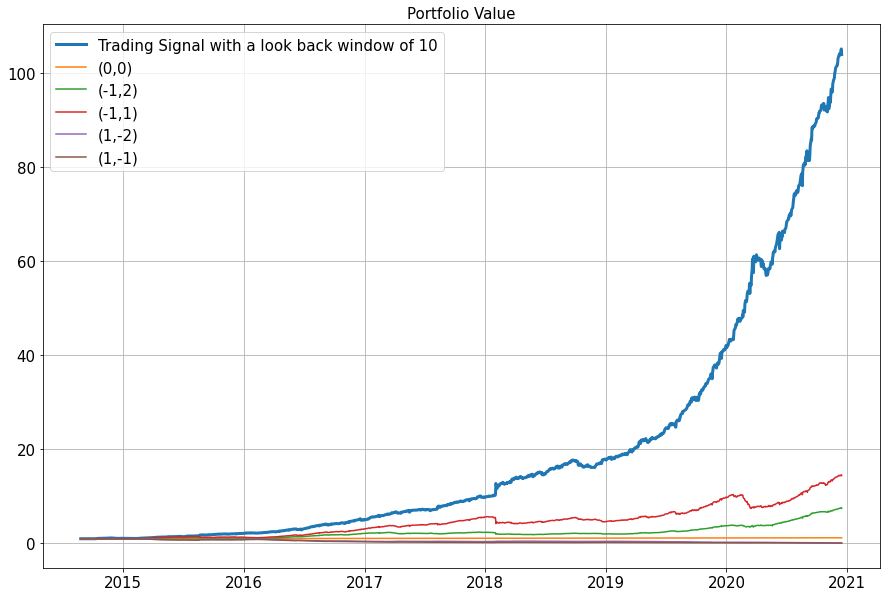

In [28]:
'''
out-of-sample portfolio using trading signal
'''

y_score = model.predict(New_test_X)
my_predict = np.argmax(y_score,axis = 1)

r_my_trade=r_trade[ind_test[:-look_back],my_predict] # 最新的資料因為lookback被剃除了
p_my_trade = np.exp(np.cumsum(np.log(1+r_my_trade)))
p_trade = np.exp(np.cumsum(np.log(1+r_trade[ind_test[:-look_back],:]),axis=0))

plt.figure(figsize = ( 15, 10 ))
plt.plot(dates[ind_test[:-look_back]],p_my_trade,
         label=f"Trading Signal with a look back window of {look_back}",linewidth=3);
labels = ["(0,0)","(-1,2)","(-1,1)","(1,-2)","(1,-1)"]
for i in range(5):
    plt.plot(dates[ind_test[:-look_back]],p_trade[:,i], label=labels[i]);
    
plt.title('Portfolio Value', fontsize = 15 )
plt.xticks( fontsize = 15 );
plt.yticks( fontsize = 15 )
plt.legend(loc="upper left",fontsize = 15)
plt.grid( which = 'major' )
plt.grid( which = 'minor', linestyle = ':' )
# plt.savefig(f'Portfolio Value with a look back window of {look_back}.png')

Accuracy Score : 42% 
Cumulative Return : 74% 
Position Return:  [ 0.02999821  0.31855589  0.42311594 -0.33903671 -0.40211071]


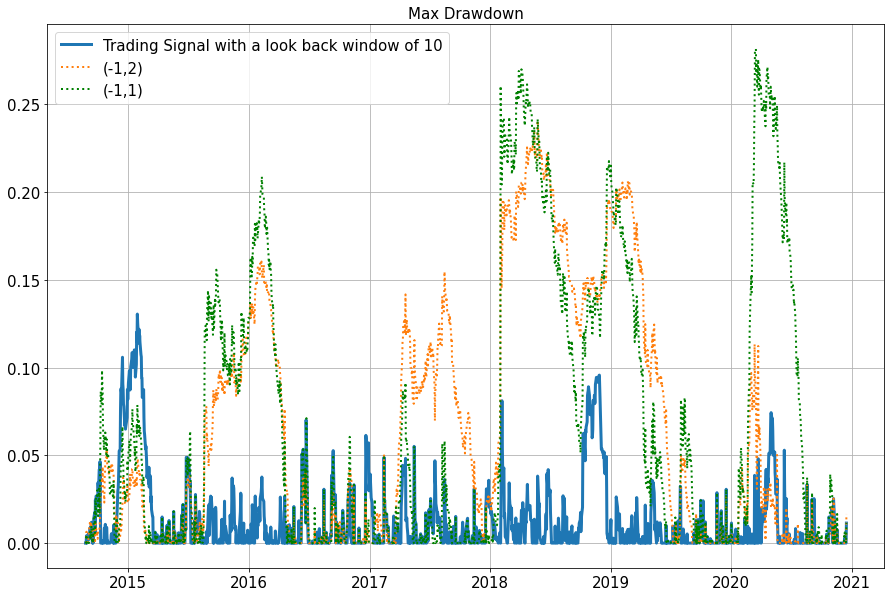

In [29]:
'''
out-of-sample portfolio return rates and max drawdowns
'''
print('Accuracy Score : {0:.0f}% '.format(metrics.accuracy_score(np.argmax(New_test_y,axis=1), my_predict)*100))
print('Cumulative Return : {0:.0f}% '.format((np.log(p_my_trade[-1])/(len(ind_test[:-look_back])*dt))*100))
print('Position Return: ',np.log(p_trade[-1])/(len(ind_test[:-look_back])*dt))

p_my_trade_discount = p_my_trade*np.exp(-r*dt*np.arange(len(ind_test[:-look_back])))
p_trade_discount = np.zeros((len(ind_test[:-look_back]),5))
for i in range(5):
    p_trade_discount[:,i] = p_trade[:,i]*np.exp(-r*dt*np.arange(len(ind_test[:-look_back])))
                                        
my_dd = 1-p_my_trade_discount/np.maximum.accumulate(p_my_trade_discount) # 分母的函數: 累積到目前為止最大的
dd = 1-p_trade_discount/np.maximum.accumulate(p_trade_discount,axis=0)

plt.figure( figsize = ( 15, 10 ) )
plt.plot(dates[ind_test[:-look_back]],my_dd,label=f"Trading Signal with a look back window of {look_back}"
        ,linewidth=3)
plt.plot(dates[ind_test[:-look_back]],dd[:,1],':',label=labels[1],linewidth=2);
plt.plot(dates[ind_test[:-look_back]],dd[:,2],'g:',label=labels[2],linewidth=2);

plt.title('Max Drawdown', fontsize = 15);
plt.xticks( fontsize = 15 );
plt.yticks( fontsize = 15 )
plt.legend(loc="upper left",fontsize = 15)
plt.grid( which = 'major' )
plt.grid( which = 'minor', linestyle = ':' )

In [30]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 110)               0         
                                                                 
 dense_10 (Dense)            (None, 1000)              111000    
                                                                 
 dense_11 (Dense)            (None, 1000)              1001000   
                                                                 
 dense_12 (Dense)            (None, 1000)              1001000   
                                                                 
 dense_13 (Dense)            (None, 1000)              1001000   
                                                                 
 dense_14 (Dense)            (None, 5)                 5005      
                                                                 
Total params: 3,119,005
Trainable params: 3,119,005
No

In [31]:
'''
Classification Report
'''
from sklearn.metrics import classification_report

y_predict=[]
for sample in y_score:
  y_predict.append([1 if i==np.max(sample) else 0 for i in sample ] )
y_predict = np.array(y_predict)
print(classification_report(New_test_y, y_predict,target_names=labels))

              precision    recall  f1-score   support

       (0,0)       0.00      0.00      0.00         0
      (-1,2)       0.29      0.16      0.20       288
      (-1,1)       0.47      0.77      0.59       723
      (1,-2)       0.12      0.07      0.08       169
      (1,-1)       0.29      0.12      0.17       410

   micro avg       0.42      0.42      0.42      1590
   macro avg       0.23      0.22      0.21      1590
weighted avg       0.36      0.42      0.36      1590
 samples avg       0.42      0.42      0.42      1590



C:\Users\jessi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jessi\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


C:\Users\jessi\anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:949: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "


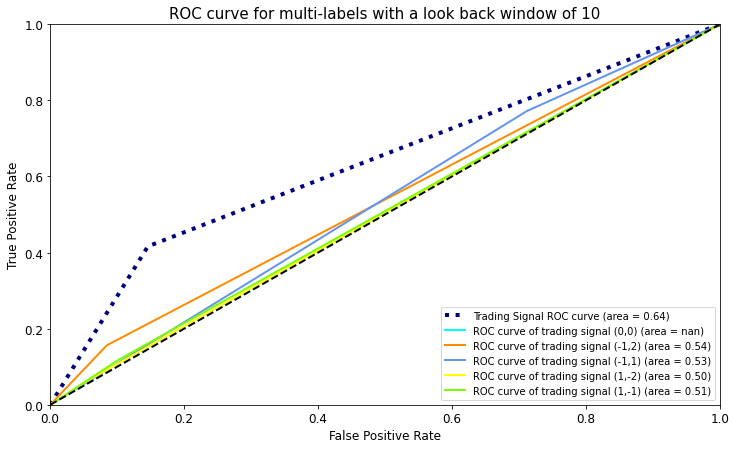

In [32]:
from itertools import cycle
from sklearn.metrics import roc_curve, auc
# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(labels)):
    fpr[i], tpr[i], _ = roc_curve(New_test_y[:, i], y_predict[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(New_test_y.ravel(), y_predict.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot all ROC curves
plt.figure(1,figsize=(12,7))
plt.plot(fpr["micro"], tpr["micro"],
         label='Trading Signal ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue','yellow','lawngreen'])
for i, color in zip(range(len(labels)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of trading signal {0} (area = {1:0.2f})'
             ''.format(labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate',fontsize = 12)
plt.ylabel('True Positive Rate',fontsize = 12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title(f'ROC curve for multi-labels with a look back window of {look_back}',fontsize = 15)
plt.legend(loc="lower right")
plt.show()
# plt.savefig(f'ROC curve for multi-label with a look back window of {look_back}.png')

Text(0.5, 0.98, 'Classification Metrics with a look back window of 10')

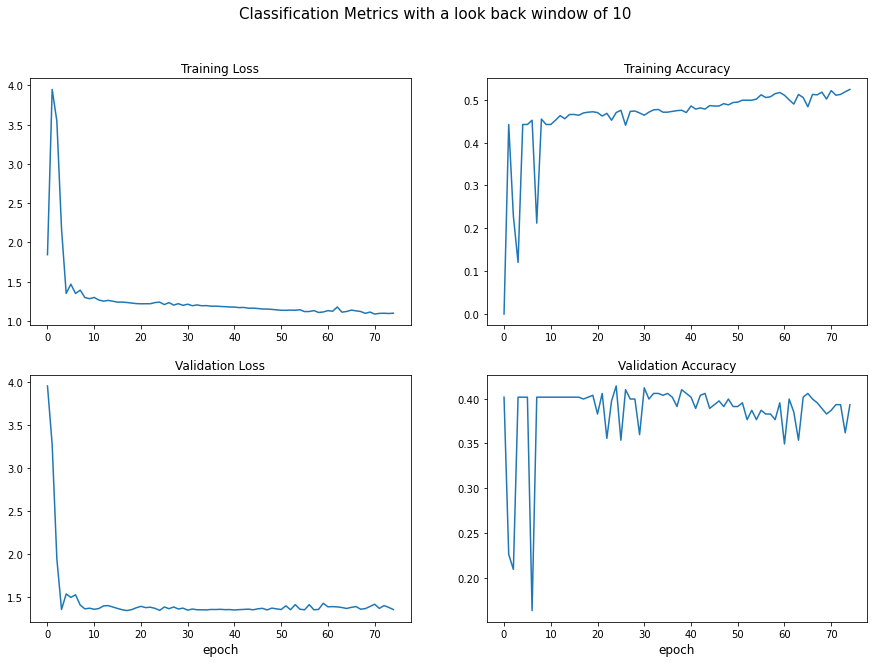

In [33]:
fig, axs = plt.subplots( 2, 2, figsize = ( 15, 10 ) )
axs[0,0].plot(model_history.history['loss'])
axs[0,0].set_title('Training Loss',fontsize = 12);

axs[0,1].plot(model_history.history['accuracy'])
axs[0,1].set_title('Training Accuracy',fontsize = 12);

axs[1,0].plot(model_history.history['val_loss'])
axs[1,0].set_title('Validation Loss',fontsize = 12);
axs[1,0].set_xlabel('epoch',fontsize = 12)

axs[1,1].plot(model_history.history['val_accuracy'])
axs[1,1].set_title('Validation Accuracy',fontsize = 12);
axs[1,1].set_xlabel('epoch',fontsize = 12);

fig.suptitle(f"Classification Metrics with a look back window of {look_back}", fontsize=15)
# plt.savefig(f'Classification Metrics with a look back window of {look_back}.png')

In [34]:
'''
ROC 分開寫

for i in range(len(labels)):
    fpr, tpr, threshold = roc_curve(New_test_y[:,i],y_score[:,i],pos_label=1) # 

    #### median, mean and optimal points on ROC curve
    ind_med = np.argmin(np.abs(threshold-np.median(y_score)))
    ind_mean = np.argmin(np.abs(threshold-np.mean(y_score)))
    ind_opt = np.argmin(np.abs(tpr-(1-fpr) ))


    plt.plot(fpr,tpr)
    plt.plot(fpr,fpr);
    plt.plot(fpr[ind_med],tpr[ind_med],'ro') 
    plt.plot(fpr[ind_mean],tpr[ind_mean],'ko'); 
    plt.plot(fpr[ind_opt],tpr[ind_opt],'go'); 
    plt.title('In-Sample ROC Curve for '+str(labels[i]));
    plt.show()

plt.hist(my_predict,40);
plt.title('In-Sample Prediction');

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-34-7e091552b8d9>, line 22)

In [ ]:
'''
ROC 老師算法


fpr, tpr, threshold = roc_curve(np.argmax(New_test_y,axis=1),my_predict,pos_label=4) # 這邊可能要改

#### median, mean and optimal points on ROC curve
ind_med = np.argmin(np.abs(threshold-np.median(y_score)))
ind_mean = np.argmin(np.abs(threshold-np.mean(y_score)))
ind_opt = np.argmin(np.abs(tpr-(1-fpr) ))


plt.plot(fpr,tpr)
plt.plot(fpr,fpr);
plt.plot(fpr[ind_med],tpr[ind_med],'ro') 
plt.plot(fpr[ind_mean],tpr[ind_mean],'ko'); 
plt.plot(fpr[ind_opt],tpr[ind_opt],'go'); 
plt.title('In-Sample ROC Curve');
plt.show()

plt.hist(my_predict,40);
plt.title('In-Sample Prediction');
